# Assignment 1

### This notebook consists of 2 parts: 
    - Power Law, 
    - Random graphs and generative network models. 

### You can receive max 20 points for both.

## Complete [this form](https://forms.gle/J9uArMMmG9L6tKGu9) with your name, email and .ipynb until 15.02 23:59 msk

In [1]:
import networkx as nx

# Power law

## 1. Guess graph by degree distribution (0 points)

Graph is described by the histogram [0, 2, 10] — 0 nodes with degree 0, 2 nodes with degree 1, 10 nodes with degree 2. The goal is to implement a function which can guess graph structure.

<BarContainer object of 3 artists>

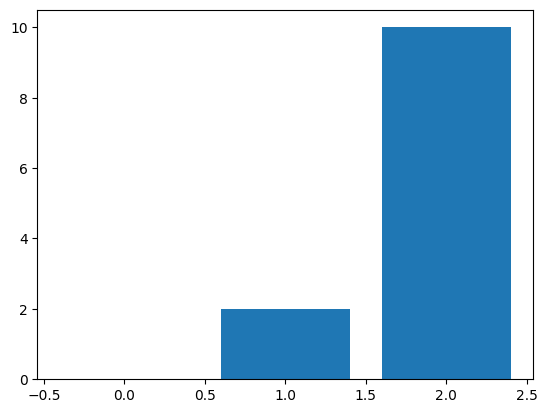

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

dens_a = [0, 2, 10]
plt.bar(range(len(dens_a)), dens_a)

In [149]:
import random

def generate_graph(nodes : np.ndarray, dens : List[int]) -> List[np.ndarray]:
    # Your code here
    if sum(dens) != len(nodes): raise RuntimeError("Wrong number of nodes")
    if len(nodes) == 0: return nx.Graph()
    
    max_degree = len(dens)
    
    available = set(nodes)
    node_dict = dict()
    
    for degree in range(1, len(dens)):
        for _ in range(dens[degree]):
            node_dict[available.pop()] = degree
            
    G = nx.Graph()
    while available:
        G.add_node(available.pop())
            
    used_pairs = set()
            
    while len(node_dict) > 1:
        node1, node2 = random.sample(list(node_dict.keys()), 2)
        print(f"nodes ({node1}, {node_dict[node1]}), ({node2}, {node_dict[node2]})")
        print(f"node dict size = {len(node_dict)}")
        if frozenset([node1, node2]) in used_pairs or (len(node_dict) > 2 and node_dict[node1] == 1 and node_dict[node2] == 1 and len(node_dict) - 3 < max_degree): continue
       
        node_dict[node1] -= 1
        node_dict[node2] -= 1
        G.add_edge(node1, node2)
        used_pairs.add(frozenset([node1, node2]))
        
        print(f"edge ({node1} -- {node2})")
        if node_dict[node1] == 0: node_dict.pop(node1)
        if node_dict[node2] == 0: node_dict.pop(node2)            
    nx.draw(G, with_labels=True)

In [150]:
# Another examples
dens_b = [0, 0, 5]
dens_c = [0, 0, 0, 0, 5]
dens_d = [0, 5, 0, 0, 0, 1]
generate_graph(range(sum(dens_b)), dens_b)

[[4, 2], [3, 2], [2, 2], [1, 2], [0, 2]]
2 0
1 2 1 2
This graph cannot exist


## 2. Gygantic connected component (1 point)

Two parameters are expected in the function input: vertices array and edges array. The goal is to implement a function that calculates the gygantic connected component.

In [4]:
# Depth-first search
def dfs(node, component, visited, adj):
    component.append(node)
    visited.add(node)
    for neighbor in adj[node]:
        if neighbor not in visited:
            dfs(neighbor, component, visited, adj)

In [10]:
def select_giant_component(vertices, edges):
    graph = {}
    for v in vertices: graph[v] = []
    
    for u, v in edges:
        graph[u].append(v)
        graph[v].append(u)

    visited = set()
    components = []

    # Loop through the vertices and find the connected components
    for v in vertices:
        if v not in visited:
            # Start a new component
            component = []
            # Perform depth-first search from the vertex
            dfs(v, component, visited, graph)
            # Add the component to the list
            components.append(component)

    # Find the largest connected component
    giant_component = max(components, key=len)

    # Return the giant component as a list of nodes
    return giant_component

## 3. Power law CDF (1 point)

Let us generate observations from a Power Law RV. The first step is to derive CDF of Powel law:  $𝐹(𝑥)=𝑃(𝑋≤𝑥)$
 
$$F(x) = 1 - \int_{x}^\infty p(t) dt.$$
 
The goal is to implement a function with imput parameters x, $\alpha$ and $x_{min}$ that calculates power law CDF. You should take the integral and derive CDF analytically. 

In [7]:
def power_law_pdf(x : float, alpha : float = 3.5, x_min : int = 1) -> float:
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

$$
F(x)=\left.c \frac{t^{-a+1}}{-a+1}\right|_{x_{\min }} ^x
$$

Simplifying and substituting the value of c, we get:
$$
F(x)=\frac{(a-1) x_{\min }^{1-a}}{-a+1}\left(x^{-a+1}-x_{\min }^{-a+1}\right)
$$

Rearranging and simplifying further, we get:
$$
F(x)=1-\left(\frac{x}{x_{\min }}\right)^{-a+1}
$$

In [152]:
def power_law_cdf(x : float, alpha : float = 3.5, x_min : int = 1) -> float:
    return 1 - (x/x_min)**(1-alpha)

## 4. Power law PPF (1 point)

Let $X \sim \text{Power law}$. Next, define a random variable $R$, s.t. $R = F(X)$, so $R$ will be uniformly distributed on interval [0, 1] ([proof](https://en.wikipedia.org/wiki/Probability_integral_transform#Proof)). Good thing here is that we easily can generate uniformly distributed pseudorandom numbers and then transform them into Power Law. Let us find an expression for $x = F^{-1}(r)$, where $r$ is an observation from uniform distrubution on interval [0, 1]. 

Find an analytical form of $F^{-1}(r)$ and implement a function `power_law_ppf` (percent point function, also known as a quantile) with parameters `r`, `alpha` and `x_min`. Here `r` is a list of observations.

In [12]:
def power_law_ppf(r : List[float], alpha : float = 3.5, x_min : int = 1) -> List[float]:
    # Your code here
    r_np = np.array(r)
    # (1-F(X))**(1/(1-alpha)) * x_min
    x = (1 - r) ** (1. / (1-alpha)) * x_min
    return x.tolist()

In [13]:
def power_law_generate(n : int, alpha : float = 3.5, x_min : int = 1, random_seed : int = 1) -> List[float]:
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 0.999, n)
    return power_law_ppf(uni_sample, alpha, x_min)

## 5. Estimation of alpha with linear binning (2 points)

Given observations from the Power Law distribution, try to estimate  𝛼
 . The easiest way is to draw an empirical PDF with linear binning in log-log scale and apply linear regression. By linear binning we mean to keep a bin width is fixed.

The goal is to implement a function alpha_lin_bins that takes a train set, number of linear bins and returns an estimated $\alpha$.

You can use the following hints:

* Take log in both side of  $𝑝(𝑥)=𝐶𝑥^{−𝛼}$
* To calculate an empirical PDF, use np.histogram(x_train, bins=bins, density=True)
* To calculate pseudoinverse matrix, use np.linalg.pinv
* Also you can fit sklearn.linear.LinearRegression

In [156]:
from sklearn.linear_model import LinearRegression

def alpha_lin_bins(x_train : list[float], bins : int) -> float:
  # Take log in both side of p(x) = Cx^−α
  log_x = np.log(x_train)
  log_p, bin_edges = np.histogram(log_x, bins=bins, density=True)
  log_p = log_p[log_p > 0]
  log_x = (bin_edges[1:] + bin_edges[:-1]) / 2 # bin centers
  log_x = log_x[:len(log_p)]

  X = np.arr([np.ones_like(log_x), log_x]) # add a column of ones to use C in the model

  model = LinearRegression()
  model.fit(X, log_p)

  alpha = -model.coef_[1]
  return alpha



## 6. Estimation of alpha with logarithmic binning (2 points)

The goal is to implement a function alpha_log_bins that takes a train set, number of log bins and returns an estimated $\alpha$.

In [155]:
def alpha_log_bins(x_train : List[float], bins : int) -> float:
  log_bins = np.logspace(np.log10(min(x_train)), np.log10(max(x_train)), bins)
  pdf, bin_edges = np.histogram(x_train, bins=log_bins, density=True)

  log_pdf = np.log(pdf)
  log_bin_edges = np.log(bin_edges)
  log_x = (log_bin_edges[1:] + log_bin_edges[:-1]) / 2
  model = LinearRegression()
  model.fit(log_x.reshape(-1, 1), log_pdf)

  alpha = -model.coef_[0]
  return alpha

## 7. Estimation parameters of Power Law by MLE (3 points)

### 7.1. Graph test data

Data for verification.
You need to take the graphs from the social network at the url_1 link to verify your programms. Each of the graphs is defined in the edges file, where each line contains a pair of vertices connected by an edge. It is assumed that there are no vertices with degree 0 in these graphs.

The url_2 link contains a transcript of all the data in the archive at url_1.

Use these dataset to test a function in 7.2.

In [7]:
url_1 = 'https://snap.stanford.edu/data/twitter.tar.gz'
url_2 = 'https://snap.stanford.edu/data/readme-Ego.txt'

In [8]:
import urllib.request
import tarfile
urllib.request.urlretrieve(url_2, "readme.txt")
urllib.request.urlretrieve(url_1, "test.tar.gz")
file = tarfile.open("test.tar.gz") 
file.extractall('./test_folder')

In [9]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [10]:
# Example: how to read edges
edges = []
for line in open('./test_folder/twitter/12831.edges', "r"):
    values = line.split()
    if not values:
        continue
    edges.append(totuple(np.array([values[0], values[1]], dtype = int)))

### 7.2. Estimation parameters of Power Law by MLE

The MLE consists of:
1. Fix $x_{min}$ as a minimal node degree (drop node degrees that less than $x_{min}$)
2. Calculate $\alpha$ via maximum likelihood estimation using fixed $x_{min}$
$$\alpha = 1 + n \left[\sum_i \log \frac{x_i}{x_{min}} \right]^{-1}$$
3. Calculate Kolmogorov-Smirnov test
4. Fix $x_{min}$ as the next node degree
5. Repeat 2-4 by scanning all possible $x_{min}$ and find the best $\alpha$ and $x_{min}$ with respect to Kolmogorov-Smirnov test

The goal is to implement a function `ml_power_law_params` that takes a node degree sequence `degree_sequence` and returns a tuple of two values: the best $\alpha$ and $x_{min}$.

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

Use the data provided in 7.1 to test your function.

In [20]:
import scipy
def mle_power_law_params(degree_sequence : List[int]) -> [float, int]:
    # Your code here
    d_s = np.array(degree_sequence)
    best_alpha, best_k_min = None, None
    best_p_value = np.inf
    for k_min in degree_sequence:
        n = float((d_s >= k_min).sum())
        alpha = 1 + n / (np.log(d_s) / np.log(k_min)).sum()
        res = scipy.stats.kstest(cdf = power_law_cdf, args=(alpha, k_min))
        if res.pvalue < best_p_value:
            best_p_value = res.pvalue
            best_k_min, best_alpha = k_min, alpha
    return [alpha, k_min]
        

# Random graphs and generative network models

## 1. Erdos-Renyi model (0.5 point)

Two parameters are expected in the function input: vertices array and p parameter. The goal is to implement Erdos-Renyi model (random graph) — each pair of  𝑛 nodes are connected with some fixed probability 𝑝.

In [123]:
import numpy as np
from typing import List, Tuple
import random

def erdos_renyi_graph(nodes : np.ndarray, p : float) -> List[np.ndarray]:
    # Your code here
    edges = []
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if random.random() <= p: edges.append((i, j))
    return edges

### 1.1. Graph visualization and test data

Data for verification.
You need to take the graphs from the social network at the url_1 link to verify your programms. Each of the graphs is defined in the edges file, where each line contains a pair of vertices connected by an edge. It is assumed that there are no vertices with degree 0 in these graphs.

The url_2 link contains a transcript of all the data in the archive at url_1.

Use this code to visualize test graphs from url provided below. This dataset is required for tests of the functions you will implement if the next tasks of this assignment.

In [35]:
url_1 = 'https://snap.stanford.edu/data/facebook.tar.gz'
url_2 = 'https://snap.stanford.edu/data/readme-Ego.txt'

In [36]:
import urllib.request
import tarfile
urllib.request.urlretrieve(url_2, "readme.txt")
urllib.request.urlretrieve(url_1, "test.tar.gz")
file = tarfile.open("test.tar.gz") 
file.extractall('./test_folder')

In [37]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [38]:
# Example: how to read edges
edges = []
for line in open('./test_folder/facebook/107.edges', "r"):
    values = line.split()
    if not values:
        continue
    edges.append(totuple(np.array([values[0], values[1]], dtype = int)))

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.Graph()
G1.add_edges_from(edges)

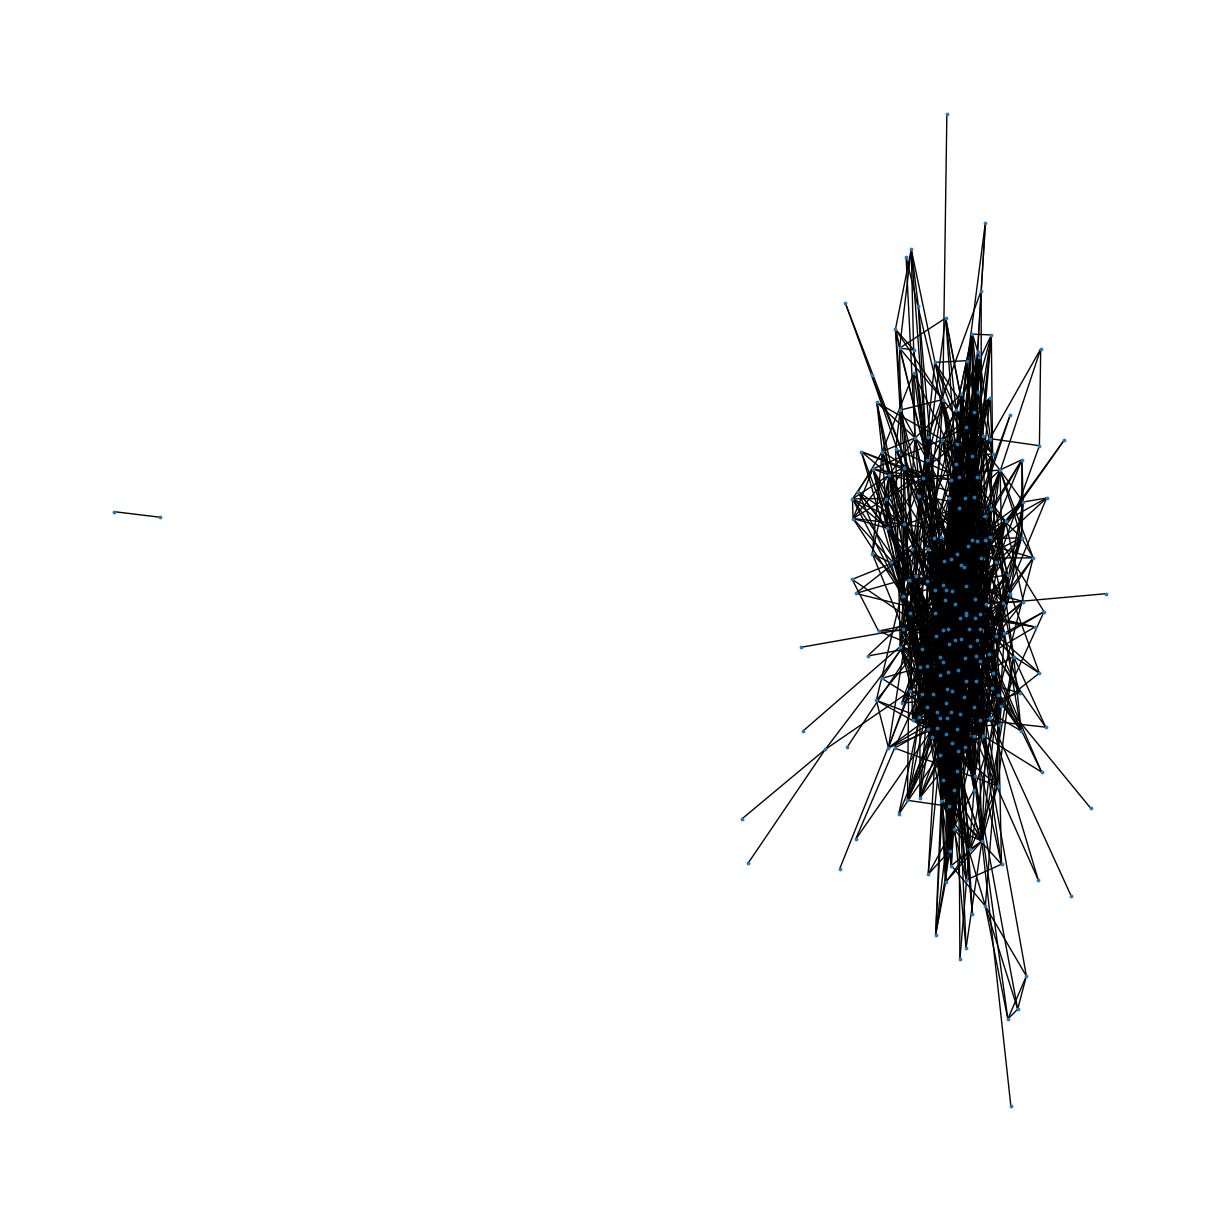

In [16]:
plt.figure(figsize=(12,12))
nx.draw(G1, node_size=3)
plt.show()

## 2. Vertices degrees distribution (0.5 point)

Two parameters are expected in the function input: vertices array and edges array. The goal is to implement a function that calculates the parameters n and p of the binomial distribution of the degrees of vertices of the graph.

Test this function of the graphs provided via the url in task 1.1.

$$\mu(x) = n \cdot p\\ $$

$$\sigma^2 = n \cdot p \cdot (1-p)\\$$

$$p = 1 - \frac{\sigma^2}{\mu(x)}\\$$

$$n=\frac{\mu(x)}{p}$$

In [19]:

def estimate_binomial(nodes : np.ndarray, edges : List[np.ndarray]) -> [int, float]:
    # Your code here
    degrees = dict().fromkeys(nodes, 0)
    for edge in edges:
        degrees[edge[0]] += 1
        degrees[edge[1]] += 1
        
    degrees_val = np.fromiter(degrees.values(), dtype=float)
    mu = degrees_val.mean()
    var = degrees_val.var()
    
    p = 1 - var/mu
    n = mu // p
    
    return n, p

print(estimate_binomial(G1.nodes, G1.edges))

(-2.0, -9.18208406255557)


## 3. Poisson distribution to evaluate a vertices degrees distribution (0.5 point)

Two parameters are expected in the function input: vertices array and edges array. The goal is to implement a function that calculates the parameters 𝜆 of the Poisson distribution of the degrees of vertices of the graph.

Test this function of the graphs provided via the url in task 1.1.

In [21]:
def estimate_poisson(nodes : np.ndarray, edges : List[np.ndarray]) -> int:
    # Your code here
    degrees = dict().fromkeys(nodes, 0)
    for edge in edges:
        degrees[edge[0]] += 1
        degrees[edge[1]] += 1
        
    degrees_val = np.fromiter(degrees.values(), dtype=float)
    return degrees_val.mean() #because lambda = mean

print(estimate_poisson(G1.nodes, G1.edges))

15.347457627118644


## 4. Graph's component average size (1 points)

Two parameters are expected in the function input: number of graph vertices and probability p for Erdos-Renyi model. The goal is to implement a function that generates random graph for each probability from probabilities array. It is required to evaluate average siz of small graph components for each graph generated. Function returns an array of average sizes.

In [28]:
from itertools import combinations
import collections

def merge(parent, x):
    if parent[x] == x:
      return x
    return merge(parent, parent[x])

def countAvgConnectedComp(n, edges):
    # list to store parents of each node
    parent = [i for i in range(n)]
 
    # loop to set parent of each node
    for x in edges:
      parent[merge(parent, x[0])] = merge(parent, x[1])
       
    # count to store number of connected components
    comp_num = 0
    # loop to count number of connected components
    for i in range(n):
      if parent[i] == i:
        comp_num += 1
     
    # loop to merge all components
    for i in range(n):
      parent[i] = merge(parent, parent[i])
 
    # map to store parent and its connected components
    m = collections.defaultdict(list)
    for i in range(n):
      m[parent[i]].append(i)
     
    # loop to print connected components
    avg = 0
    for child in m.values():
      avg += child
    avg /= comp_num
     
    return avg
# https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/

def generate_Erdos_Renyi_graph(nodes: np.ndarray, probability: float) -> (np.ndarray, np.ndarray):
    vertices = []
    for i, j in combinations(nodes, 2):
        if random.random() <= probability:
            vertices.append((nodes[i], nodes[j]))
    return (nodes, vertices)    

def largest_connection_component(nodes : int, probabilities : np.ndarray) -> np.ndarray:
    # Your code here
    # Graph = (nodes, vertices)
    output_graphs = []
    for p in probabilities:
        output_graphs.append(generate_Erdos_Renyi_graph(range(nodes), p))
    return np.array(output_graphs).apply(lambda x: countAvgConnectedComp(nodes, x[1]))

## 5. Graph's shortest path average length (1 points)

Two parameters are expected in the function input: the first array contains average degrees of graphs, the second one contains amount of graphs vertices. The goal is to generate random graphs with corresponding average degree and amount of vertices. Function is expected to return an array of average lengths of graphs shortest paths.

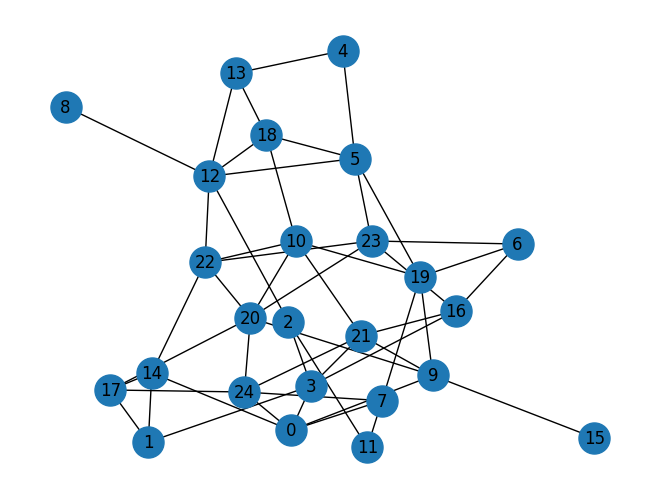

array([2.3328])

In [72]:
import random
def get_random_pair(arr: np.array) -> (int, int):
    copy = list(arr)
    random.shuffle(copy)
    return copy[:2]

def graph_by_avg_degree(average_degree: float, nodes_number: int) -> (np.array, np.array):
    degrees_sum = average_degree * nodes_number
    used_vertices = set()
    nodes = range(nodes_number)
    
    while degrees_sum > 0:
        while True:
            n1, n2 = get_random_pair(nodes)
            pair = frozenset((n1, n2))
            if pair in used_vertices: continue
            used_vertices.add(pair)
            # degrees are added pairwise, so it's impossible to get odd degrees_sum
            degrees_sum -= 2
            break
    
    return np.array(nodes), np.fromiter(map(lambda v: tuple(v), used_vertices), tuple)


def Djikstra(AdjMatrix, vertice) -> np.ndarray:
    n_vertices = len(AdjMatrix)
    dist = np.array([float('inf')] * n_vertices)
    dist[vertice] = 0
    used = set()
    unused = set(range(n_vertices))

    while unused:
        # Pick the minimum distance vertex from
        # the set of vertices not yet processed.
        # u is always equal to src in first iteration
        min = float('inf')
        u = next(iter(unused))
        for uwu in unused:
            if min > dist[uwu]:
                u = uwu
                min = dist[uwu]
        
        # Put the minimum distance vertex in the
        # shortest path tree
        unused.remove(u)
        
        # Update dist value of the adjacent vertices
        # of the picked vertex only if the current
        # distance is greater than new distance and
        # the vertex in not in the shortest path tree
        for v in range(n_vertices):
            if (AdjMatrix[u][v] > 0 and
                v in unused and
                dist[v] > dist[u] + AdjMatrix[u][v]):
                dist[v] = dist[u] + AdjMatrix[u][v]
    return np.array(dist)

def avg_short_path(vertices, edges): 
    E = set(map(lambda x: frozenset(x), edges))
    AdjMatrix = [None] * len(vertices)
    for i in range(len(AdjMatrix)): AdjMatrix[i] = np.array([0] * len(vertices))
    for v in vertices:
        e = set(filter(lambda el: v in el, E))
        for v1, v2 in e:
            AdjMatrix[v1][v2] = 1
            AdjMatrix[v2][v1] = 1
    # print("AdjMatrix")
    # for line in AdjMatrix: print(line)
    AdjMatrix = np.array(AdjMatrix)


    rows, cols = np.where(AdjMatrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, with_labels=True)
    plt.show()

    avgs = []
    for v in vertices:
        paths = Djikstra(AdjMatrix, v)
        # print(f'from djikstra: {paths}')
        # paths[paths == float('inf')] = 0
        paths = paths[paths != float('inf')]
        # print(f'changed from djikstra: {paths}')
        avgs.append(paths.mean())
        
    return np.array(avgs).mean()

def average_shortest_path_length(average_degree : np.ndarray, nodes_number : np.ndarray) -> np.ndarray:
    # Your code here
    # https://networkx.org/documentation/networkx-1.3/reference/generated/networkx.average_shortest_path_length.html#:~:text=The%20average%20shortest%20path%20length%20is%20the%20sum%20of%20path,number%20of%20nodes%20in%20G.
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html
    paths = []
    for avg_d, nodes in zip(average_degree, nodes_number):
        vertices, edges = graph_by_avg_degree(avg_d, nodes)
        paths.append(avg_short_path(vertices, edges))
    
    return np.array(paths)
    
average_shortest_path_length([4], [25])
        

## 6. Clustering coefficient (0.5 point)

Two parameters are expected in the function input: vertices array and p parameter for Erdos-Renyi model. The goal is to generate a random graph and calculate all vertices' degrees and clustering coefficients.

In [125]:
from itertools import combinations
from iteration_utilities import first
def clustering_coefficient(nodes : np.ndarray, p : float) -> [np.ndarray, np.ndarray]:
    # Your code here
    edges = erdos_renyi_graph(nodes, p)
    edges = set(map(frozenset, edges))
    degrees = []
    clustering_coefs = []
    for node in nodes:
        neighbours = set()
        for edge in edges:
            if node in edge:
                v1, v2 = edge
                neighbours.add(v1 if v1 != node else v2)
        degrees.append(len(neighbours))
        
        counter = 0.
        length = len(neighbours)
        for pair in combinations(neighbours, 2):
                if frozenset(pair) in edges: counter+=1
        clustering_coefs.append(2.* counter / (length * (length-1)))
    
    return np.array(degrees), np.array(clustering_coefs)
    

clustering_coefficient(range(10), 0.5)

(array([5, 8, 3, 6, 3, 6, 4, 5, 5, 5]),
 array([0.5       , 0.5       , 0.66666667, 0.53333333, 0.66666667,
        0.53333333, 0.83333333, 0.4       , 0.5       , 0.7       ]))

## 7. Watts-Strogatz model (2 point)

The goal is to implement a function Watts-Strogatz model (small-world model) — rewire an edge with probability $p$ in a ring lattice with $n$ nodes and $k$ degree.

This function should be splitted into little functions described below.

there was function, but it's below now

A ring_lattice function generates a regular ring lattice with $n$ nodes $(0, 1, 2, ..., n-1)$ and $k$ node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [91]:
def ring_lattice(nodes : np.ndarray, k : int) -> List[np.ndarray]:
    # Your code here
    k = k-1 if k%2 else k
    vertices = []
    for i in range(len(nodes)):
        for j in range(k-1):
            vertices.append((nodes[i], nodes[(i+j+1) % len(nodes)]))
    return vertices

A function `rewire` takes in input a ring lattice defined by adjacency list `AdjList`. The other input parameters are: a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.*

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)

* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

Function should return rewired adjacency list.

In [146]:
from random import choice, random

def rewire(AdjList : List[np.ndarray], node : int, k : int, p : float) -> List[np.ndarray]:
    # Your code here
    if len(AdjList) == 0: return
    adj = set(map(frozenset, AdjList))
    nodes = set(map(lambda pair: pair[0],AdjList)) | set(map(lambda pair: pair[1],AdjList))
    for j in range(-1,k):
        if j == 0: continue
        if random() < p:
            adj.discard(frozenset([node, (node+j) % len(nodes)]))
            chosen_one = choice(list(nodes.difference({(node+j) % len(nodes), node})))
            adj.add(frozenset((node, chosen_one)))
    return list(map(lambda x: np.array(list(x)), adj))


In [83]:
from tqdm.notebook import tqdm
def watts_strogatz_graph(nodes : np.ndarray, k : int, p : float) -> List[np.ndarray]:
    AdjList = ring_lattice(nodes, k)
    for node in tqdm(nodes):
        AdjList = rewire(AdjList, node, k, p) 
    return AdjList

In [147]:
watts_strogatz_graph(range(10), 2, 0.2)

  0%|          | 0/10 [00:00<?, ?it/s]

[array([3, 4]),
 array([9, 6]),
 array([2, 3]),
 array([0, 3]),
 array([8, 9]),
 array([2, 6]),
 array([5, 6]),
 array([8, 4]),
 array([5, 7]),
 array([0, 9])]

## 8. Barabasi-Albert model (2 point)

The goal is to implement Barabasi-Albert model (preferential attachment model) -- a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is 
$$p(i) = \frac{k_i}{\sum k}$$

The function requres another function described below.

In [145]:
from tqdm import trange

def barabasi_albert_graph(nodes : np.ndarray, m : int) -> List[np.ndarray]:
    AdjList = list(nx.star_graph(m).edges)
    for i in trange(1, len(nodes) - m):
        attach(m + i, AdjList, m)
    return AdjList

A function `attach` attaches a `node` to a graph `G` through `m` edges. It should not return any variables but just change an adjacency list passed to the input.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [146]:
import operator
from functools import reduce

def attach(node : int, AdjList : List[np.ndarray], m : int) -> None:
    # Your code here
    pool = list(reduce(operator.concat, AdjList))
    for _ in range(m):
        el = choice(pool)
        pool = list(filter((el).__ne__, pool)) 
        AdjList.append((node, el))
        

In [148]:
barabasi_albert_graph(range(5), 3)

100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


[(0, 1), (0, 2), (0, 3), (4, 0), (4, 2), (4, 1)]

## 9. Degree dynamics in Barabasi-Albert model (2 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

The goal is to implement a function generate_degree_dynamics that takes np.array with considered nodes, generates Barabasi-Albert graph ( 𝑛=3000
 ,  𝑚=6
 ) and returns a np.array of the shape (30, len(cons_nodes)) — degrees of these nodes at time moments when nodes 99, 199, 299, ..., 2999 appear. If a node does not exist yet, pass np.nan value.

Hint: use the barabasi_albert_graph function as a template.

In [ ]:
def generate_degree_dynamics(cons_nodes):
    # YOUR CODE HERE
    raise NotImplementedError()